# **Amusement Park simulator using SimPy**

This simulator models guest flow throughout Universal Studios Singapore (USS) on a regular day.

Visitors are generated in batches, simulating the arrival of guests at the park.
Each visitor follows a process that simulates their movement and decisions throughout their stay.
The visitor starts from the park entrance and selects attractions to visit based on desirability of each attraction.

In line with USS's annual attendance of approximately 4 million, the simulation models the behaviour of approximately 10 thousand visitors.

### Visitor Actions:

Each simulated visitor can perform the following actions:

- **Travel to Chosen Attraction**: 
  - Once an attraction is selected, the visitor "travels" to it
  - The travel time is approximated by the distance between the attraction and the visitor
- **Experience the Attraction**: 
  - If the visitor can access the attraction without excessive waiting, they spend time enjoying it, after which the visit is recorded in their history.
  - If the chosen attraction is a restaurant, the visitor "spends money" there.
- **Queue Reneging**: 
  - If the waiting time is too long, the visitor may "renege" (leave the queue) and forgo visiting the attraction.

### Desirability & Adjustments:

The selection of attractions for each simulated visitor is influenced by the **"desirability"** of each attraction. Desirability represents the likelihood of a visitor choosing a particular attraction and is calculated as follows:

**For Restaurants:**
1. We gathered each restaurant's average Google rating and estimated price range.
2. A desirability score was then computed for each restaurant, where higher ratings increased desirability, while lower price ranges further boosted it.

**For Rides:**
1. We used aggregated survey data capturing respondents' perceived likelihood of visiting each ride.
2. These scores were benchmarked against each other to assess each ride’s relative attractiveness.
3. The relative likelihood was then multiplied by a factor of 3, based on our assumption that visitors are significantly more inclined to choose rides over restaurants.

### Dynamic Adjustment of Desirability:
The desirability of each attraction also dynamically adjusts based on:
1. **Proximity**: Attractions closer to a visitor’s current location have increased desirability, as visitors tend to favor nearby options.
2. **Time-Based Adjustment**: During lunch and dinner hours, restaurant desirability levels are increased while ride desirability levels are decreased, as visitors are more likely to visit restaurants during these peak times.

### Other Visitor Considerations/Constraints:

**Patience Level:**
  - Represents the maximum amount of time that a visitor is willing to wait for an attraction.
  - This is based on aggregated survey data.

**Maximum Number of Visits to Restaurants:**
  - Fixed at 2 visits per visitor.
  - This limit results in a spending level that aligns with a study (Geissler & Rucks, 2011) showing that most visitors spend an average of about $25 on food.

**Maximum Number of Visits to Rides:**
  - If a ride has been visited before, it is deprioritized in the visitor’s selection.
  - Each ride can be visited a maximum of 3 times.


--- 

# **Business Problem**

### Problem Statement
Our team aims to enhance the guest experience at the attraction by optimizing attraction layouts, schedules, and operations. Specifically, we are focusing on reducing wait times, increasing guest satisfaction, and boosting revenue through effective flow management and demand-based adjustments.

### Key Considerations
- **Wait Time**: Reducing wait times for dining and attractions to improve guest flow and experience.
- **Guest Satisfaction**: Enhancing the overall experience by reducing wait times and improving affordability of food.
- **Revenue**: Increasing revenue opportunities by incentivizing purchases during non-peak hours.

# **Proposed Solution**

### Happy Hour Discount
To incentivize guests to dine during non-peak hours, we propose a **happy hour discount of xx%** on food purchases. This discount aims to:
- Redistribute demand for dining services throughout the day
- Reduce congestion in peak dining hours, allowing for better guest flow and shorter wait times
- Increase revenue by attracting more purchases during off-peak times

### Impact
- **Reduced Wait Times**: By shifting demand to off-peak hours, wait times for both dining and attractions are expected to decrease.
- **Improved Guest Satisfaction**: Enhanced guest experience from having to renege less and from experiencing better food affordability.
- **Revenue Growth**: Increased food purchases during non-peak hours contribute to overall revenue growth without adding strain to peak times.

### Assumptions:
- Decrease in price will result in a more than proportional increase in quantity demanded, evidenced by the findings of Ewing et al. (2023) that showed a 1% change in price resulted in a 7.98% change in quantity demanded
- Guests' perceived desirability of restaurants during peak meal hours will increase to a smaller extent, as they are incentivised to have meals during Happy Hours instead


In [304]:
import pandas as pd
import pickle

sim_curr = pickle.load(open( "parksim_records.p", "rb" ) )
guests_curr = sim_curr['guests']
venues_curr = sim_curr['attractions']

sim_hh = pickle.load(open( "parksim_records_with_changes.p", "rb" ) )
guests_hh = sim_hh['guests']
venues_hh = sim_hh['attractions']

In [305]:
eventdata_curr = []
for attraction_name in venues_curr:
    for event in venues_curr[attraction_name]['events']:
        eventdata_curr.append({
            'attraction': attraction_name,
            'type': event[0],
            'time': event[1],
            'queuelength': event[2]
        })

eventdata_curr = pd.DataFrame(eventdata_curr)

eventdata_hh = []
for attraction_name in venues_hh:
    for event in venues_hh[attraction_name]['events']:
        eventdata_hh.append({
            'attraction': attraction_name,
            'type': event[0],
            'time': event[1],
            'queuelength': event[2]
        })

eventdata_hh = pd.DataFrame(eventdata_hh)

In [306]:
import pandasql as ps

eventdata_curr['time_interval'] = pd.cut(
    eventdata_curr['time'],
    bins=[i for i in range(0, 570, 30)],
    labels=[i for i in range(1, 19)] )

eventdata_curr['time_interval'] = pd.to_numeric(eventdata_curr['time_interval'], errors='coerce')

query = """
SELECT 
    attraction, 
    time_interval, 
    AVG(queuelength) AS avg_queuelength, 
    MAX(queuelength) AS max_queuelength, 
    COUNT(queuelength) AS count_events
FROM eventdata_curr
WHERE time <= 540  -- Ensure time is within the 9-hour range
GROUP BY attraction, time_interval
ORDER BY attraction, time_interval ASC
"""

result_df_curr = ps.sqldf(query, locals())
result_df_curr['time_interval'] = result_df_curr['time_interval'].astype(int)

eventdata_hh['time_interval'] = pd.cut(
    eventdata_hh['time'],
    bins=[i for i in range(0, 570, 30)],
    labels=[i for i in range(1, 19)] )

eventdata_hh['time_interval'] = pd.to_numeric(eventdata_hh['time_interval'], errors='coerce')

query = """
SELECT 
    attraction, 
    time_interval, 
    AVG(queuelength) AS avg_queuelength, 
    MAX(queuelength) AS max_queuelength, 
    COUNT(queuelength) AS count_events
FROM eventdata_hh
WHERE time <= 540  -- Ensure time is within the 9-hour range
GROUP BY attraction, time_interval
ORDER BY attraction, time_interval ASC
"""

result_df_hh = ps.sqldf(query, locals())
result_df_hh['time_interval'] = result_df_hh['time_interval'].astype(int)

start_time = pd.Timestamp('2024-11-05 10:00:00')  # Adjust the date as needed

result_df_curr['datetime'] = start_time + pd.to_timedelta(result_df_curr['time_interval'] * 30, unit='m')
result_df_hh['datetime'] = start_time + pd.to_timedelta(result_df_hh['time_interval'] * 30, unit='m')

# **Wait Times**

Wait times for each attraction depend on several factors:
- **Visitor Queue Size**: The number of visitors waiting in line.
- **Ride Capacity and Duration**: Information on each ride’s capacity and duration, sourced online.

### Impact of the Happy Hour Discount
The introduction of a **happy hour discount** on food has helped reduce wait times by:
- **Diverting Demand During Peak Meal Hours**: By encouraging visitors to dine during peak meal hours, demand for food increases while ride demand decreases, helping reduce congestion at attractions.
- **Shifting Visitors to Restaurants During Happy Hours**: During happy hours, visitors are incentivized to choose dining over waiting for rides, further balancing the demand between attractions and restaurants.

### Data Visualization
- **Wait Time Maps**: The maps provides a visual representation of how wait times fluctuate across the day before and after implementing the Happy Hour Discount.
- **Average Wait Time Comparison**: The graphs below illustrate the difference in average wait times for each attraction throughout the day, comparing data from before and after the implementation of the happy hour discount.


In [307]:
import folium
from folium.plugins import TimestampedGeoJson

attraction_coords = pd.read_csv("attractions_locations.csv")[['name', 'lat', 'long', 'type']]
attraction_coords.columns = attraction_coords.columns.str.strip()

'''result_df_curr['queue_category'] = pd.cut(
    result_df_curr['avg_queuelength'],
    bins=[-float('inf'), result_df_curr['avg_queuelength'].quantile(0.33), result_df_curr['avg_queuelength'].quantile(0.66), float('inf')],
    labels=['Low', 'Medium', 'High']
)'''

merged_df_curr = pd.merge(result_df_curr, attraction_coords, left_on='attraction', right_on='name', how='left')


features = []
'''for _, row in merged_df_curr.iterrows():
    if row['type'] == 'ride':
        features.append({
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row['long'], row['lat']]
            },
            'properties': {
                'time': (start_time + pd.to_timedelta((row['time_interval'] - 1) * 30, unit='m')).isoformat(),  # Start time
                'style': {
                    'color': 'red' if row['queue_category'] == 'High' else 'orange' if row['queue_category'] == 'Medium' else 'green',
                    'radius': row['avg_queuelength'] / 50
                },
                'icon': 'circle',
            }
        })
    else:
        features.append({
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row['long'], row['lat']]
            },
            'properties': {
                'time': (start_time + pd.to_timedelta((row['time_interval'] - 1) * 30, unit='m')).isoformat(),  # Start time
                'style': {
                    'color': 'red' if row['queue_category'] == 'High' else 'orange' if row['queue_category'] == 'Medium' else 'green',
                    'radius': row['avg_queuelength'] / 50
                },
                'icon': 'circle',
            }
        })'''

for _, row in merged_df_curr.iterrows():
    if row['type'] == 'ride':
        features.append({
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row['long'], row['lat']]
            },
            'properties': {
                'time': (start_time + pd.to_timedelta((row['time_interval'] - 1) * 30, unit='m')).isoformat(),  # Start time
                'style': {
                    'color': 'green',
                    'radius': row['avg_queuelength'] / 50
                },
                'icon': 'circle',
            }
        })
    else:
        features.append({
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row['long'], row['lat']]
            },
            'properties': {
                'time': (start_time + pd.to_timedelta((row['time_interval'] - 1) * 30, unit='m')).isoformat(),  # Start time
                'style': {
                    'color': 'blue',
                    'radius': row['avg_queuelength'] / 50
                },
                'icon': 'circle',
            }
        })


map_center = [merged_df_curr['lat'].mean(), merged_df_curr['long'].mean()]
m_curr = folium.Map(location=map_center, zoom_start=17, zoom_control=True, scrollWheelZoom=False)

TimestampedGeoJson(
    {
        'type': 'FeatureCollection',
        'features': features
    },
    period='PT30M',
    duration ='PT29M',
    add_last_point=True,
    auto_play=True,
    loop=True,
).add_to(m_curr)

m_curr

In [308]:
result_df_hh['queue_category'] = pd.cut(
    result_df_hh['avg_queuelength'],
    bins=[-float('inf'), result_df_hh['avg_queuelength'].quantile(0.33), result_df_hh['avg_queuelength'].quantile(0.66), float('inf')],
    labels=['Low', 'Medium', 'High']
)

merged_df_hh = pd.merge(result_df_hh, attraction_coords, left_on='attraction', right_on='name', how='left')


features = []
'''for _, row in merged_df_hh.iterrows():
    if row['type'] == 'ride':
        features.append({
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row['long'], row['lat']]
            },
            'properties': {
                'time': (start_time + pd.to_timedelta((row['time_interval'] - 1) * 30, unit='m')).isoformat(),  # Start time
                'style': {
                    'color': 'red' if row['queue_category'] == 'High' else 'orange' if row['queue_category'] == 'Medium' else 'green',
                    'radius': row['avg_queuelength'] / 50
                },
                'icon': 'circle',
            }
        })
    else:
        features.append({
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row['long'], row['lat']]
            },
            'properties': {
                'time': (start_time + pd.to_timedelta((row['time_interval'] - 1) * 30, unit='m')).isoformat(),  # Start time
                'style': {
                    'color': 'red' if row['queue_category'] == 'High' else 'orange' if row['queue_category'] == 'Medium' else 'green',
                    'radius': row['avg_queuelength'] / 50
                },
                'icon': 'circle',
            }
        })'''
for _, row in merged_df_hh.iterrows():
    if row['type'] == 'ride':
        features.append({
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row['long'], row['lat']]
            },
            'properties': {
                'time': (start_time + pd.to_timedelta((row['time_interval'] - 1) * 30, unit='m')).isoformat(),  # Start time
                'style': {
                    'color': 'green',
                    'radius': row['avg_queuelength'] / 50
                },
                'icon': 'circle',
            }
        })
    else:
        features.append({
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row['long'], row['lat']]
            },
            'properties': {
                'time': (start_time + pd.to_timedelta((row['time_interval'] - 1) * 30, unit='m')).isoformat(),  # Start time
                'style': {
                    'color': 'blue',
                    'radius': row['avg_queuelength'] / 50
                },
                'icon': 'circle',
            }
        })


map_center = [merged_df_hh['lat'].mean(), merged_df_hh['long'].mean()]
m_hh = folium.Map(location=map_center, zoom_start=17, zoom_control=True, scrollWheelZoom=False)

TimestampedGeoJson(
    {
        'type': 'FeatureCollection',
        'features': features
    },
    period='PT30M',
    duration ='PT29M',
    add_last_point=True,
    auto_play=True,
    loop=True,
).add_to(m_hh)

m_hh

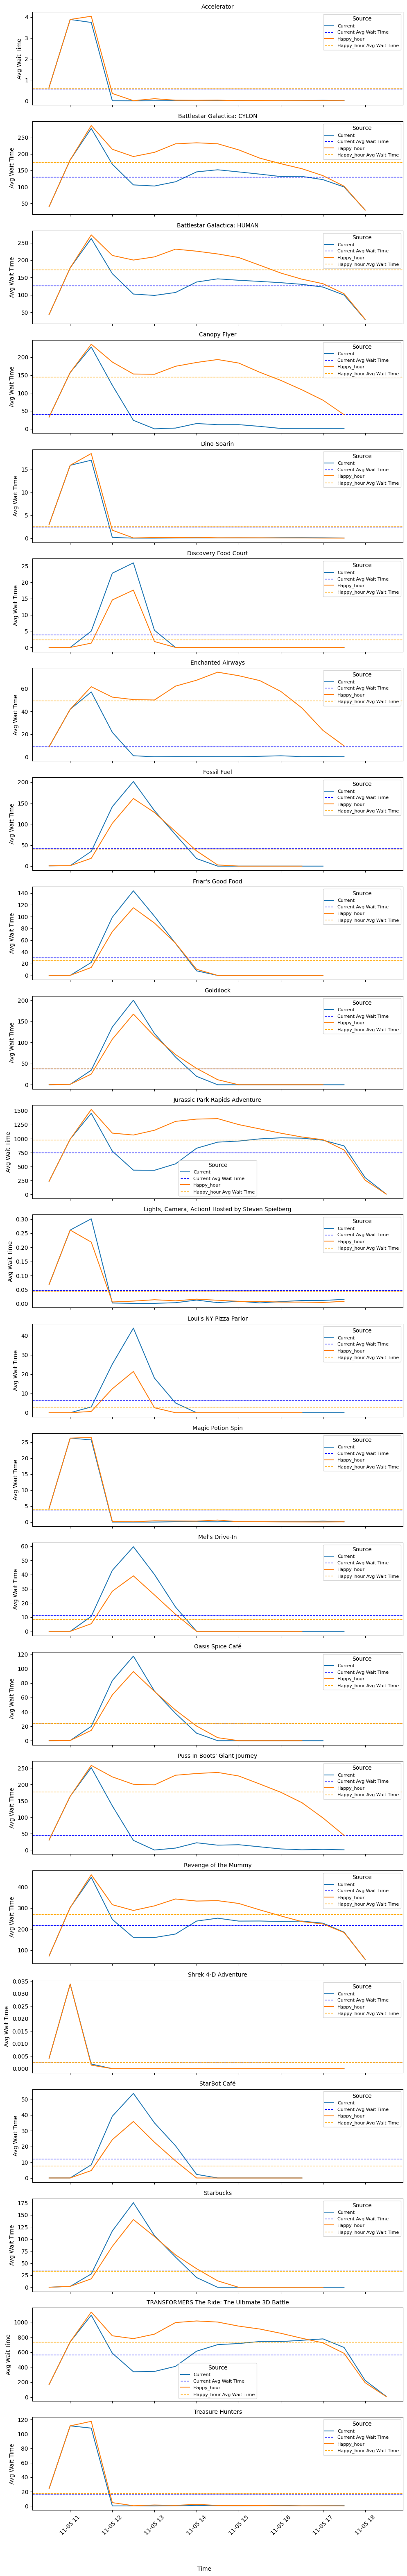

In [309]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'datetime' is in the correct datetime format
result_df_curr['datetime'] = pd.to_datetime(result_df_curr['datetime'])
result_df_hh['datetime'] = pd.to_datetime(result_df_hh['datetime'])

# Add a 'source' column to differentiate the datasets
result_df_curr['source'] = 'current'
result_df_hh['source'] = 'happy_hour'

attractions = pd.read_csv("attractions.csv")[['name', 'capacity', 'Duration (s)']]
attractions.columns = attractions.columns.str.strip()

# Combine the two dataframes
combined_result_df = pd.concat([result_df_curr, result_df_hh])
merged_result_df = pd.merge(combined_result_df, attractions, left_on='attraction', right_on='name', how='left')
merged_result_df['waittime'] = (merged_result_df['avg_queuelength'] / merged_result_df['capacity']) * merged_result_df['Duration (s)'] / 60
# Get the unique attractions for subplots
unique_attractions = combined_result_df['attraction'].unique()

# Set up the subplots with a more compact figure size
fig, axes = plt.subplots(len(unique_attractions), 1, figsize=(10, len(unique_attractions) * 3), sharex=True)

# If there's only one subplot, ensure axes is iterable
if len(unique_attractions) == 1:
    axes = [axes]

# Loop through each attraction and create a subplot
for i, attraction in enumerate(unique_attractions):
    ax = axes[i]
    data = merged_result_df[merged_result_df['attraction'] == attraction]
    
    # Plot avg_queuelength over datetime for the current attraction
    for source in ['current', 'happy_hour']:
        source_data = data[data['source'] == source]
        ax.plot(source_data['datetime'], source_data['waittime'], label=f"{source.capitalize()}")

        # Calculate and plot the average wait time line with specific colors
        avg_wait_time = source_data['waittime'].mean()
        color = 'blue' if source == 'current' else 'orange'
        ax.axhline(y=avg_wait_time, color=color, linestyle='--', linewidth=1,
                   label=f"{source.capitalize()} Avg Wait Time")

    # Adding labels and title to each subplot
    ax.set_ylabel('Avg Wait Time')
    ax.set_title(f'{attraction}', fontsize=10)
    ax.legend(title='Source', fontsize=8)

    # Rotate x-axis labels for readability only on the last subplot
    if i == len(unique_attractions) - 1:
        ax.tick_params(axis='x', rotation=45)

# Set a single x-axis label for the figure
fig.text(0.5, 0.04, 'Time', ha='center')

# Adjust layout and spacing
plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust top and bottom spacing
plt.show()


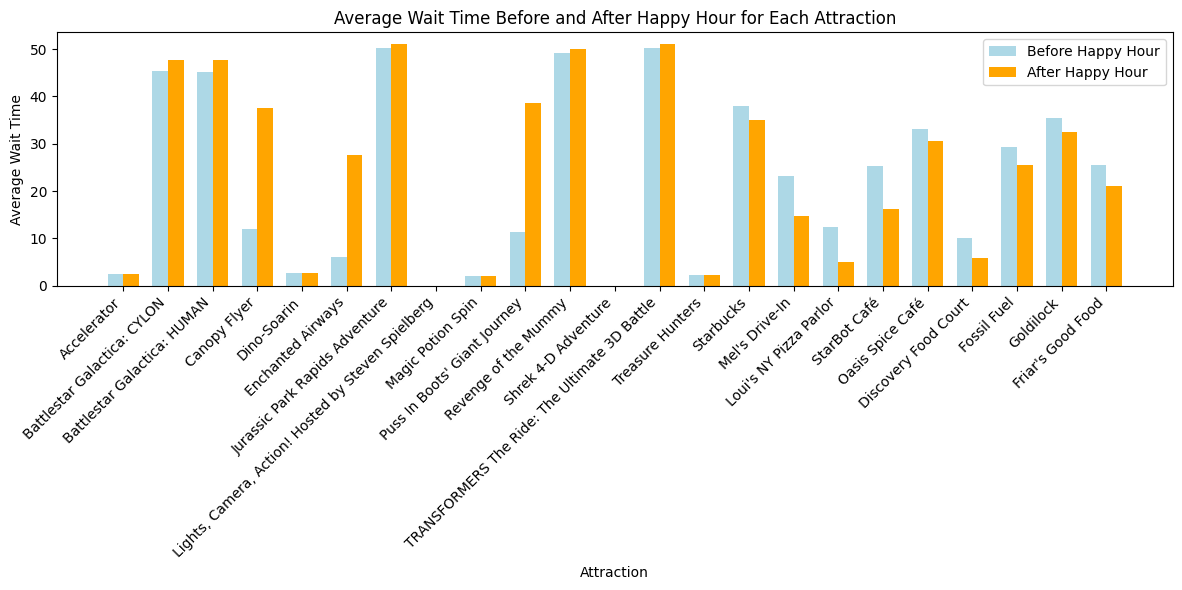

In [310]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the venues_curr and venues_hh dictionaries, where each venue contains a list of wait times

# Initialize lists to store average wait times before and after happy hour
attractions = []
avg_wait_before = []
avg_wait_after = []

# Loop through each attraction in the current and happy hour datasets
for attraction in venues_curr.keys():
    # Calculate the average wait time before and after happy hour
    avg_wait_curr = np.mean(venues_curr[attraction]['wait_times']) if venues_curr[attraction]['wait_times'] else 0
    avg_wait_hh = np.mean(venues_hh[attraction]['wait_times']) if venues_hh[attraction]['wait_times'] else 0
    
    # Append the data for plotting
    attractions.append(attraction)
    avg_wait_before.append(avg_wait_curr)
    avg_wait_after.append(avg_wait_hh)

# Set the positions for the bars
bar_width = 0.35
index = np.arange(len(attractions))

# Create the bar chart with a larger figure size for spacing
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bars for before and after happy hour
bar1 = ax.bar(index - bar_width/2, avg_wait_before, bar_width, label='Before Happy Hour', color='lightblue')
bar2 = ax.bar(index + bar_width/2, avg_wait_after, bar_width, label='After Happy Hour', color='orange')

# Add labels, title, and custom x-ticks
ax.set_xlabel('Attraction')
ax.set_ylabel('Average Wait Time')
ax.set_title('Average Wait Time Before and After Happy Hour for Each Attraction')
ax.set_xticks(index)  # Positioning the x-ticks in the middle of the groups
ax.set_xticklabels(attractions, rotation=45, ha='right')  # Rotate and align labels to the right
ax.legend()

# Adjust layout for spacing
plt.tight_layout()
plt.show()


# **Guest Satisfaction**

Based on survey feedback, we identified **wait times** and **food affordability** as two primary factors to improve guest satisfaction.

### Key Metrics for Guest Satisfaction

- **Wait Times (Reneges)**: We use the number of *reneges* (when visitors leave the queue due to excessive wait times) as an indicator of long wait times. High numbers of reneges suggest that wait times exceed visitors' individual patience levels.
  
- **Food Affordability**: Food affordability is measured by the average cost per restaurant visit, which directly impacts guest satisfaction. Lower average costs are expected to increase satisfaction.

### Impact of the Happy Hour Program

The **happy hour discount** was introduced to address these satisfaction factors:
- By incentivizing guests to dine during non-peak hours, we aim to reduce queue congestion and thereby decrease wait times and reneges.
- The discount also makes dining more affordable, helping improve perceptions of food affordability.

### Data Visualization

- **Reneges**: A **bar chart** showing the number of reneges throughout the day, comparing data from before and after the happy hour implementation, would illustrate the effect of the program on wait times.
  
- **Food Affordability**: A **bar chart** displaying the average cost per restaurant visit across different time periods, with and without the happy hour discount, would help visualize changes in perceived affordability.

These graphs are shown below to highlight improvements in both wait times (via reduction in reneges) and food affordability under the happy hour program.


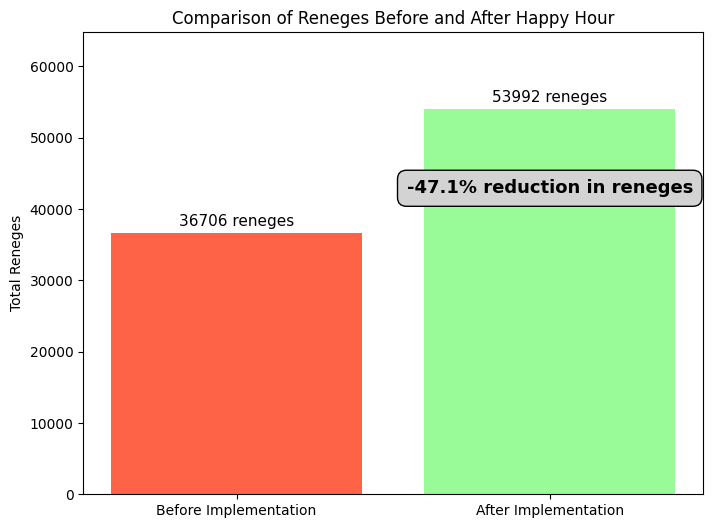

In [311]:
import matplotlib.pyplot as plt

# Calculate total reneges before and after happy hour
total_reneges_before = sum(venues_curr[x]['reneged_count'] for x in venues_curr)
total_reneges_after = sum(venues_hh[x]['reneged_count'] for x in venues_hh)

# Calculate the percentage decrease in reneges after happy hour
reneges_after_percentage_of_before = (total_reneges_after / total_reneges_before) * 100
percentage_decrease = 100 - reneges_after_percentage_of_before

# Data for bar chart
conditions = ['Before Implementation', 'After Implementation']
reneges_counts = [total_reneges_before, total_reneges_after]
colors = ['#FF6347', '#98FB98']  # Colors for before and after

# Plot bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(conditions, reneges_counts, color=colors)

# Adjust y-axis limit to make room for labels above the bars
plt.ylim(0, max(reneges_counts) * 1.2)

# Annotate bars with reneges counts and percentage change
for bar, count in zip(bars, reneges_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, count + 0.01 * max(reneges_counts),
             f'{count} reneges', ha='center', va='bottom', color='black', fontsize=11)

# Display percentage decrease annotation, positioned slightly higher
plt.text(1, min(reneges_counts) * 1.15,
         f'{percentage_decrease:.1f}% reduction in reneges',
         ha='center', color='black', fontsize=13, fontweight='bold',
         bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='round,pad=0.5'))


# Labels and title
plt.ylabel('Total Reneges')
plt.title('Comparison of Reneges Before and After Happy Hour')
plt.show()


# **Revenue**

### Price Sensitivity and Demand Assumption
Survey feedback indicated that **food affordability** is a key factor influencing guest satisfaction. Based on this, we assume that visitors are **highly price sensitive**—meaning a decrease in price is likely to lead to a more than proportional increase in the quantity of food demanded.

### Impact of the Happy Hour Program on Revenue
- Although food prices are lowered during the happy hour, the **increase in quantity demanded** is substantial, especially during peak hours.
- As a result, overall **revenue from food sales** increases, even with the discount in place, due to the higher volume of purchases.

### Data Visualization
- **Quantity Demanded**: A **bar chart** showing the number of restaurant visits before and after the happy hour implementation, tracked across different attractions, would illustrate the program’s impact on quantity demanded.
- **Revenue Comparison**: A **bar chart** comparing total revenue from food sales before and after the happy hour implementation, would illustrate the program’s impact on revenue.


These visualizations would demonstrate how the happy hour program affects both revenue and quantity demanded, highlighting the program’s success in increasing food sales while maintaining affordability.


Demand is likely price elastic due to how important a consideration it is

Affordability increases qty demanded to a more than proportial increase
revenue increase


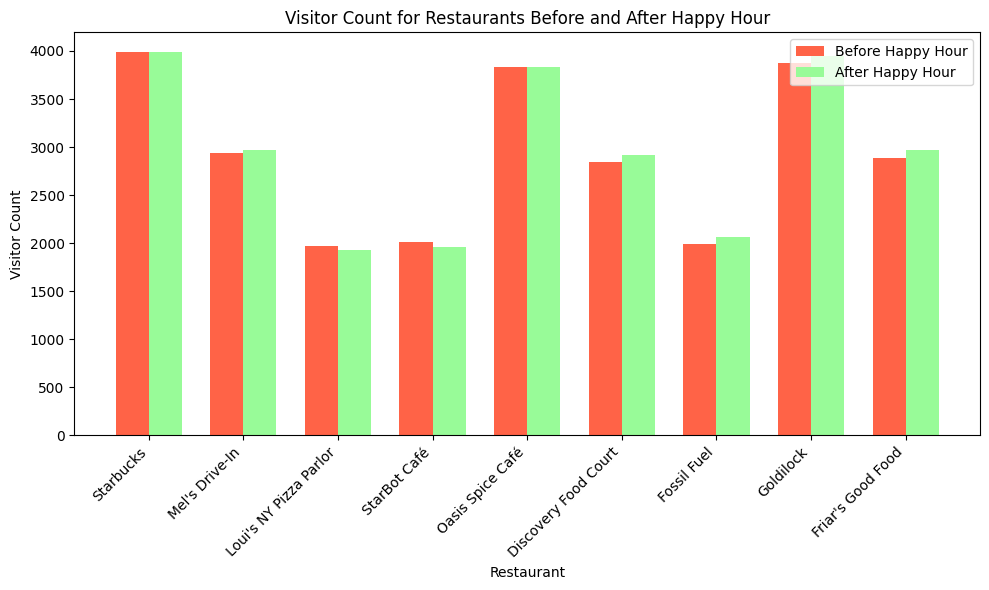

In [312]:
import matplotlib.pyplot as plt

# Filter the venues dataframes to include only restaurants
restaurants_curr = {x: venues_curr[x] for x in venues_curr if venues_curr[x]['type'] == 'restaurant'}
restaurants_hh = {x: venues_hh[x] for x in venues_hh if venues_hh[x]['type'] == 'restaurant'}

# Extract the names of the restaurants
restaurant_names = list(restaurants_curr.keys())

# Get the visitor count before and after happy hour for each restaurant
visitor_count_before = [restaurants_curr[x]['visitor_count'] for x in restaurant_names]
visitor_count_after = [restaurants_hh[x]['visitor_count'] for x in restaurant_names]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Set width of bars
bar_width = 0.35

# X locations for the bars
index = range(len(restaurant_names))

# Plot the bars for before and after
bars_before = ax.bar(index, visitor_count_before, bar_width, label='Before Happy Hour', color='#FF6347')
bars_after = ax.bar([i + bar_width for i in index], visitor_count_after, bar_width, label='After Happy Hour', color='#98FB98')

# Adding labels
ax.set_xlabel('Restaurant')
ax.set_ylabel('Visitor Count')
ax.set_title('Visitor Count for Restaurants Before and After Happy Hour')
ax.set_xticks([i + bar_width / 2 for i in index])  # Place the x-ticks in the middle of the bars
ax.set_xticklabels(restaurant_names, rotation=45, ha='right')  # Rotate restaurant names for readability

# Add a legend
ax.legend()

# Display the chart
plt.tight_layout()
plt.show()


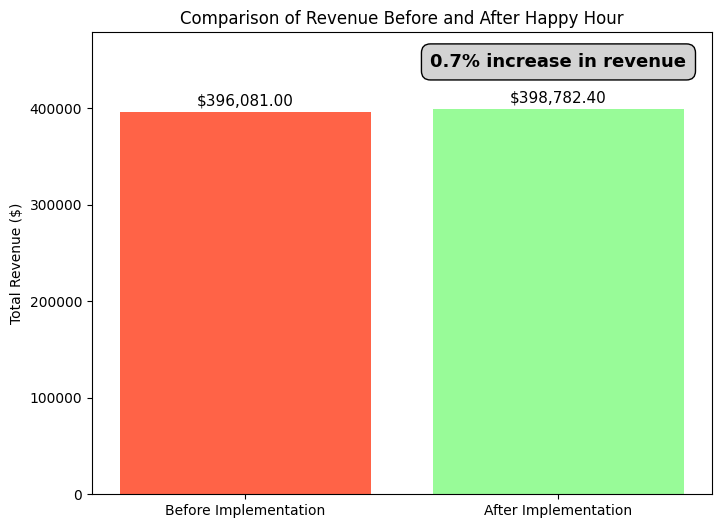

In [313]:

# Assuming the 'revenue' column exists in both 'venues_curr' and 'venues_hh'
# venues_curr[x]['revenue'] and venues_hh[x]['revenue']

# Calculate total revenue before and after happy hour by summing the 'revenue' column
total_revenue_before = sum(venues_curr[x]['revenue'] for x in venues_curr)
total_revenue_after = sum(venues_hh[x]['revenue'] for x in venues_hh)

# Calculate the percentage increase in revenue after happy hour
revenue_after_percentage_of_before = (total_revenue_after / total_revenue_before) * 100
percentage_increase = revenue_after_percentage_of_before - 100  # This gives the increase in percentage

# Data for bar chart
conditions = ['Before Implementation', 'After Implementation']
revenue_values = [total_revenue_before, total_revenue_after]
colors = ['#FF6347', '#98FB98']  # Colors for before and after

# Plot bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(conditions, revenue_values, color=colors)

# Adjust y-axis limit to make room for labels above the bars
plt.ylim(0, max(revenue_values) * 1.2)

# Annotate bars with revenue values and percentage change
for bar, revenue in zip(bars, revenue_values):
    plt.text(bar.get_x() + bar.get_width() / 2, revenue + 0.01 * max(revenue_values),
             f'${revenue:,.2f}', ha='center', va='bottom', color='black', fontsize=11)

# Display percentage increase annotation, positioned slightly higher
plt.text(1, max(revenue_values) * 1.11,
         f'{percentage_increase:.1f}% increase in revenue',
         ha='center', color='black', fontsize=13, fontweight='bold',
         bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='round,pad=0.5'))

# Labels and title
plt.ylabel('Total Revenue ($)')
plt.title('Comparison of Revenue Before and After Happy Hour')
plt.show()

In [314]:
revenue = 0
guests = 0
visits = 0
reneges = 0

for guest in guests_curr:
    revenue += guests_curr[guest]['spending']
    guests += 1
    visits += guests_curr[guest]['restaurant_visits']
    reneges += guests_curr[guest]['reneges']

print("curr")
print("revenue: $", revenue )
print("restaurant visits:", visits)
print("cost per restaurant visit:", revenue / visits)
print("spending per customer:", revenue / guests)
print("reneges:", reneges)
print("guests:", guests)

print("-------")

revenue = 0
guests = 0
visits = 0
reneges = 0

for guest in guests_hh:
    revenue += guests_hh[guest]['spending']
    guests += 1
    visits += guests_hh[guest]['restaurant_visits']
    reneges += guests_hh[guest]['reneges']

print("happy hour")
print("revenue: $", revenue )
print("restaurant visits:", visits)
print("cost per restaurant visit:", revenue / visits)
print("spending per customer:", revenue / guests)
print("reneges:", reneges)
print("guests:", guests)

curr
revenue: $ 396081
restaurant visits: 26348
cost per restaurant visit: 15.0326780021254
spending per customer: 29.798450195606378
reneges: 36706
guests: 13292
-------
happy hour
revenue: $ 398782.39999999997
restaurant visits: 26575
cost per restaurant visit: 15.005922859830667
spending per customer: 30.001685224195
reneges: 53992
guests: 13292
